In [1]:
import os
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization, Dropout
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [ ]:
from google.colab import drive
drive.mount('cnontent/')

In [ ]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

In [2]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [5]:
train_df = pd.read_csv("../../data/emnist-byclass-train.csv", header=None)
test_df = pd.read_csv("../../data/emnist-byclass-test.csv", header=None)

In [6]:
X_train, y_train  = convert_data_csv_to_numpy(train_df)
X_test, y_test  = convert_data_csv_to_numpy(test_df)

train_df = None
test_df = None

In [7]:
# add channel
# channel = 3
# X_train_3 = np.repeat(X_train, channel, axis=-1)
# X_test_3 = np.repeat(X_test, channel, axis=-1)
# y_test_3 = y_test

X_train, X_val, y_train, y_val = train_test_split(X_train/255., y_train, test_size=0.2, random_state=42)
# X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_3, y_train, test_size=0.2, random_state=42)

In [8]:
raw_y_train = y_train.copy()
raw_y_val = y_val.copy()
raw_y_test = y_test.copy()

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

# VGG

In [9]:
inputs = Input(shape = (28,28,1))
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(inputs)
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block  
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 5th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers  
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 62, activation ='softmax')(x)
# creating the model

VGG_model_2 = Model (inputs=inputs, outputs =output)
VGG_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496 

In [11]:
VGG_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_new_emnist_model.h5", save_best_only=True)
vgg_hitory = VGG_model_2.fit(X_train, y_train, batch_size = 512, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 34s 30ms/step - loss: 0.9071 - accuracy: 0.7190 - val_loss: 0.5531 - val_accuracy: 0.8199
Epoch 2/100
1091/1091 [==============================] - 32s 29ms/step - loss: 0.4650 - accuracy: 0.8405 - val_loss: 0.7804 - val_accuracy: 0.8293
Epoch 3/100
1091/1091 [==============================] - 32s 30ms/step - loss: 0.4205 - accuracy: 0.8527 - val_loss: 0.4330 - val_accuracy: 0.8548
Epoch 4/100
1091/1091 [==============================] - 32s 29ms/step - loss: 0.4003 - accuracy: 0.8586 - val_loss: 0.4329 - val_accuracy: 0.8518
Epoch 5/100
1091/1091 [==============================] - 31s 29ms/step - loss: 0.3851 - accuracy: 0.8622 - val_loss: 0.4251 - val_accuracy: 0.8552
Epoch 6/100
1091/1091 [==============================] - 32s 29ms/step - loss: 0.3743 - accuracy: 0.8649 - val_loss: 0.4001 - val_accuracy: 0.8587
Epoch 7/100
1091/1091 [==============================] - 32s 29ms/step - loss: 0.3646 - accuracy: 0.8673 - val_loss: 0

In [12]:
def plt_learning_curve(history, model_name):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.title(f"{model_name}'s learnig curve", fontsize=14)
  plt.show()

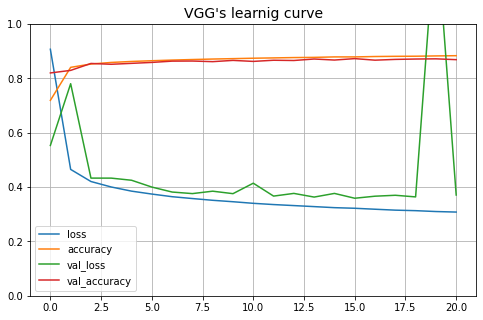

In [13]:
plt_learning_curve(vgg_hitory, 'VGG')

# Lenet

In [14]:
keras.backend.clear_session()

lenet_5_selu_dropout_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=1,  activation="selu", kernel_initializer="lecun_normal", input_shape=(28, 28, 1), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(62, activation='softmax')
])

lenet_5_selu_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 32)       1

In [15]:
lenet_5_selu_dropout_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

lenet_history = lenet_5_selu_dropout_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 18s 16ms/step - loss: 1.4630 - accuracy: 0.6384 - val_loss: 0.8801 - val_accuracy: 0.7534
Epoch 2/100
1091/1091 [==============================] - 17s 15ms/step - loss: 0.6490 - accuracy: 0.7993 - val_loss: 0.7550 - val_accuracy: 0.7693
Epoch 3/100
1091/1091 [==============================] - 17s 16ms/step - loss: 0.5504 - accuracy: 0.8203 - val_loss: 0.5765 - val_accuracy: 0.8094
Epoch 4/100
1091/1091 [==============================] - 17s 16ms/step - loss: 0.5084 - accuracy: 0.8305 - val_loss: 0.5863 - val_accuracy: 0.8071
Epoch 5/100
1091/1091 [==============================] - 17s 16ms/step - loss: 0.4833 - accuracy: 0.8367 - val_loss: 0.5105 - val_accuracy: 0.8289
Epoch 6/100
1091/1091 [==============================] - 17s 15ms/step - loss: 0.4662 - accuracy: 0.8408 - val_loss: 0.5207 - val_accuracy: 0.8266
Epoch 7/100
1091/1091 [==============================] - 17s 16ms/step - loss: 0.4551 - accuracy: 0.8435 - val_loss: 0

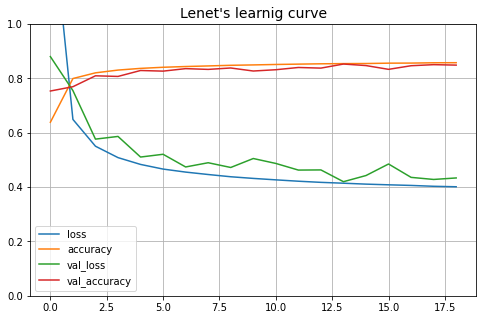

In [16]:
plt_learning_curve(lenet_history, 'Lenet')